### Import OpenVisus and add one utility function to load images from disk or network

In [1]:
import sys,os,numpy,cv2
from   skimage.metrics import structural_similarity as ssim
from   PIL import Image,ImageChops
from   urllib.request import urlopen
import matplotlib.pyplot as plt
import tempfile
import shutil
import ssl # this is needed for apple (urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed )

%matplotlib inline

# if you have OpenVisus binary dir somewhere not in site-packages
sys.path.append(r'D:\projects\OpenVisus\build\RelWithDebInfo')
from OpenVisus import *

# utility to load images
def LoadImage(filename):
    if filename.startswith('http'):
        filename=urlopen(filename,context=ssl.SSLContext() ) 
        size=int(filename.info()['Content-Length'])
    else:
        size=os.stat(filename).st_size
    ret=Image.open(filename)
    ret=numpy.asarray(ret)
    print('Loaded',filename,'size',size)
    return [ret,size]

def ShowImage(data):
    fig =  plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()
    
def rmse(predictions, targets):
    return numpy.sqrt(((predictions - targets) ** 2).mean())
    
# function to test db compression and show diff
# function to test db compression and show diff
def TestCompression(compression,data=None):
    
    # Here I'm assuming I have RGB data uint8 (i.ei bitsperblock=15 corresponds to 2^15*3/1024=96KB)
    bitsperblock=15

    # one file per dataset
    blocksperfile=-1    
    
    idx_filename='tmp/test_idx_block_compression/visus.idx'
    
    # remove old directory if exists
    shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)
 
    db=CreateIdx(
        url=idx_filename, 
        filename_template='./visus.bin', 
        dim=2,
        data=data, 
        bitsperblock=bitsperblock, 
        blocksperfile=-1,
        compression=compression)
    
    idx_size=os.stat('tmp/test_idx_block_compression/visus.bin').st_size 
    print('Created compressed db','Compression ratio in comparison to source data {:.2f}'.format(idx_size/src_size))
    
    # read a little preview
    idx_preview=db.read(x=[0,src_preview.shape[1]],y=[0,src_preview.shape[0]])
    if filter is not None:
        idx_preview=idx_preview[:,:,0:3] # last channels are just coefficients
        
    print('RMSE (preview):', rmse(src_preview,idx_preview))
    
    # show diff1 using image difference
    diff1=numpy.array(ImageChops.difference(Image.fromarray(src_preview), Image.fromarray(idx_preview)))
    print('diff [min, max, mean]:', [numpy.min(diff1), numpy.max(diff1), numpy.mean(diff1)])
    
    # show diff2 using structure similarity
    __score__,diff2 = ssim(src_preview, idx_preview, full=True, multichannel=True)
    print('sm [min, max, mean]:', [numpy.min(diff2), numpy.max(diff2), numpy.mean(diff2)])
    diff2=(diff2+1.0)*0.5
    diff2=(diff2*255.0).astype(numpy.uint8)
    
    ShowImage(idx_preview)
    ShowImage(diff1)
    ShowImage(diff2)

print('OpenVisus imported and utils added')

OpenVisus imported and utils added


### Open one source image which will be compared to IDX compressed one

Loaded <http.client.HTTPResponse object at 0x000001A7FC4ABD88> size 12583052
Loaded <http.client.HTTPResponse object at 0x000001A7FC545FC8> size 4194426
Src image loaded SrcSize 12 MB shape (2048, 2048, 3) dtype uint8


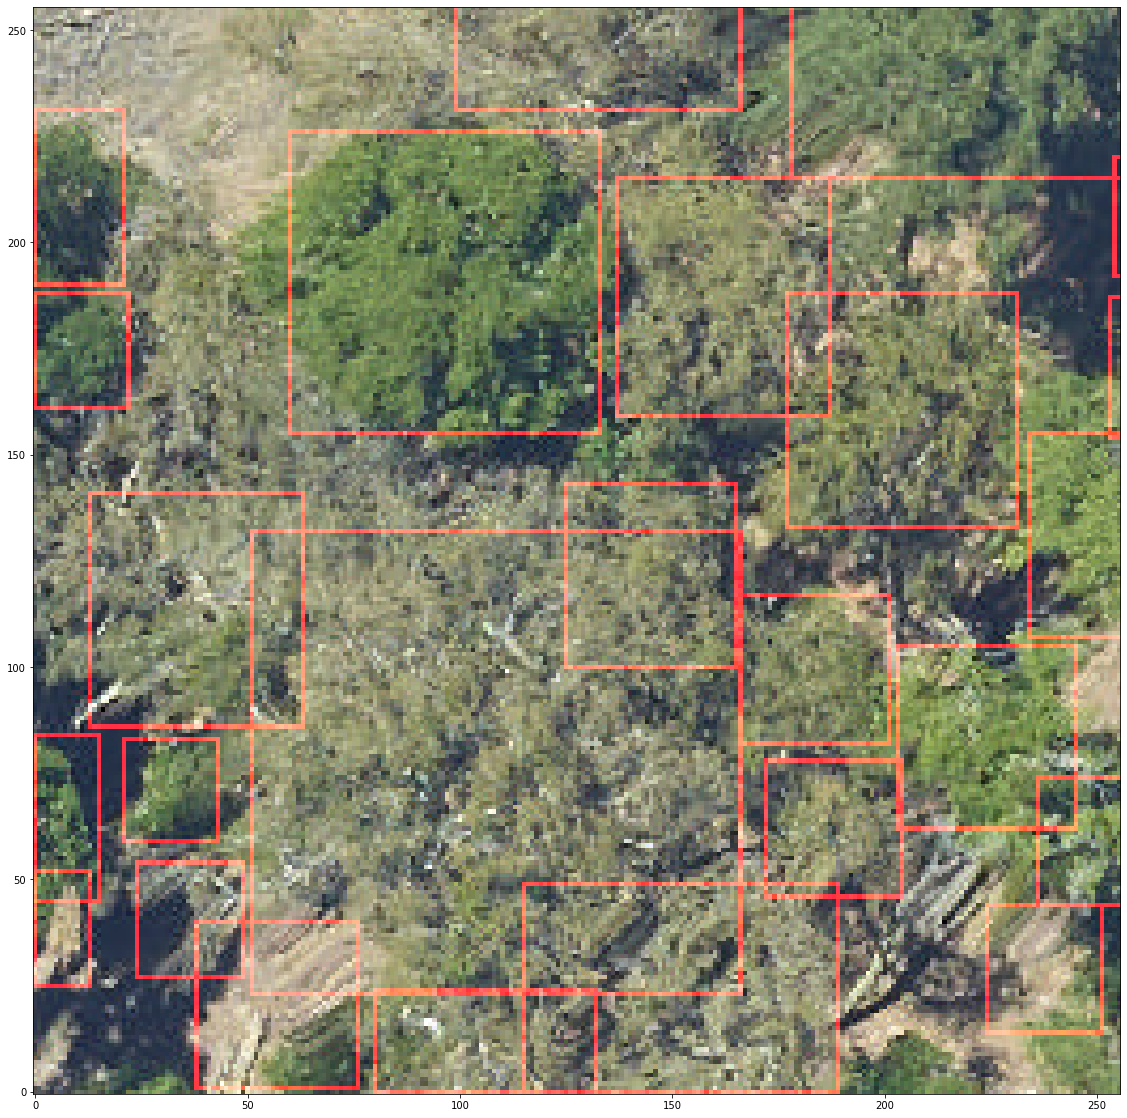

In [2]:
test='neon'

if test=='neon':
    # show red lines (annotations from 'rasterize' file)
    prefix='https://github.com/sci-visus/OpenVisus/releases/download/test__compression/2019_OSBS_5_402000_3284000'
    src,src_size=LoadImage(prefix + '_image.small.tif')
    ras,ras_size=LoadImage(prefix + '_image_rasterized.small.tif')
    src=numpy.copy(src)
    src[:,:,0][ras>0]=255
    preview_size=256
    src_preview=src[0:preview_size,0:preview_size,:]
    
if test=='david':
    src,src_size=LoadImage('https://is4-ssl.mzstatic.com/image/thumb/Purple3/v4/ed/b1/08/edb108f6-aa0c-e3ad-97e5-00a15329b5eb/mzl.oqyivrxl.png/643x0w.jpg')
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src
    
if test=='hdr':
    src,src_size=LoadImage('https://color.viewsonic.com/asset-files/images/journal/High-Dynamic-Range.jpg')
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src    
    
print('Src image loaded','SrcSize',int(src_size/(1024*1024)),'MB','shape',src.shape,'dtype',src.dtype)
ShowImage(src_preview)

### Loss-less zip compression: idx binary file is too big, obviously no artifacts

Created compressed db Compression ratio in comparison to source data 0.92
RMSE (preview): 0.0
diff [min, max, mean]: [0, 0, 0.0]
sm [min, max, mean]: [1.0, 1.0, 1.0]


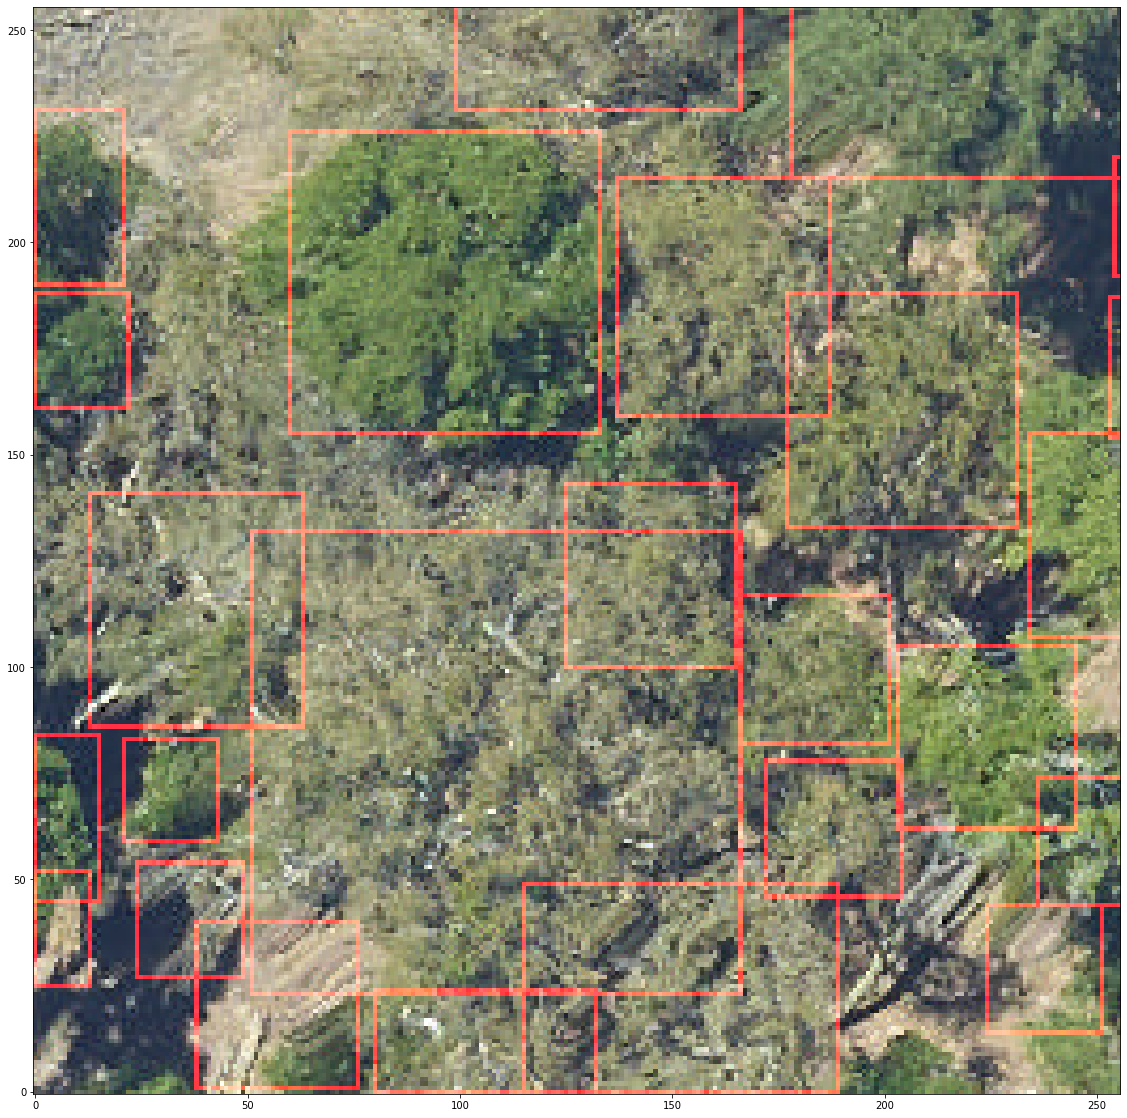

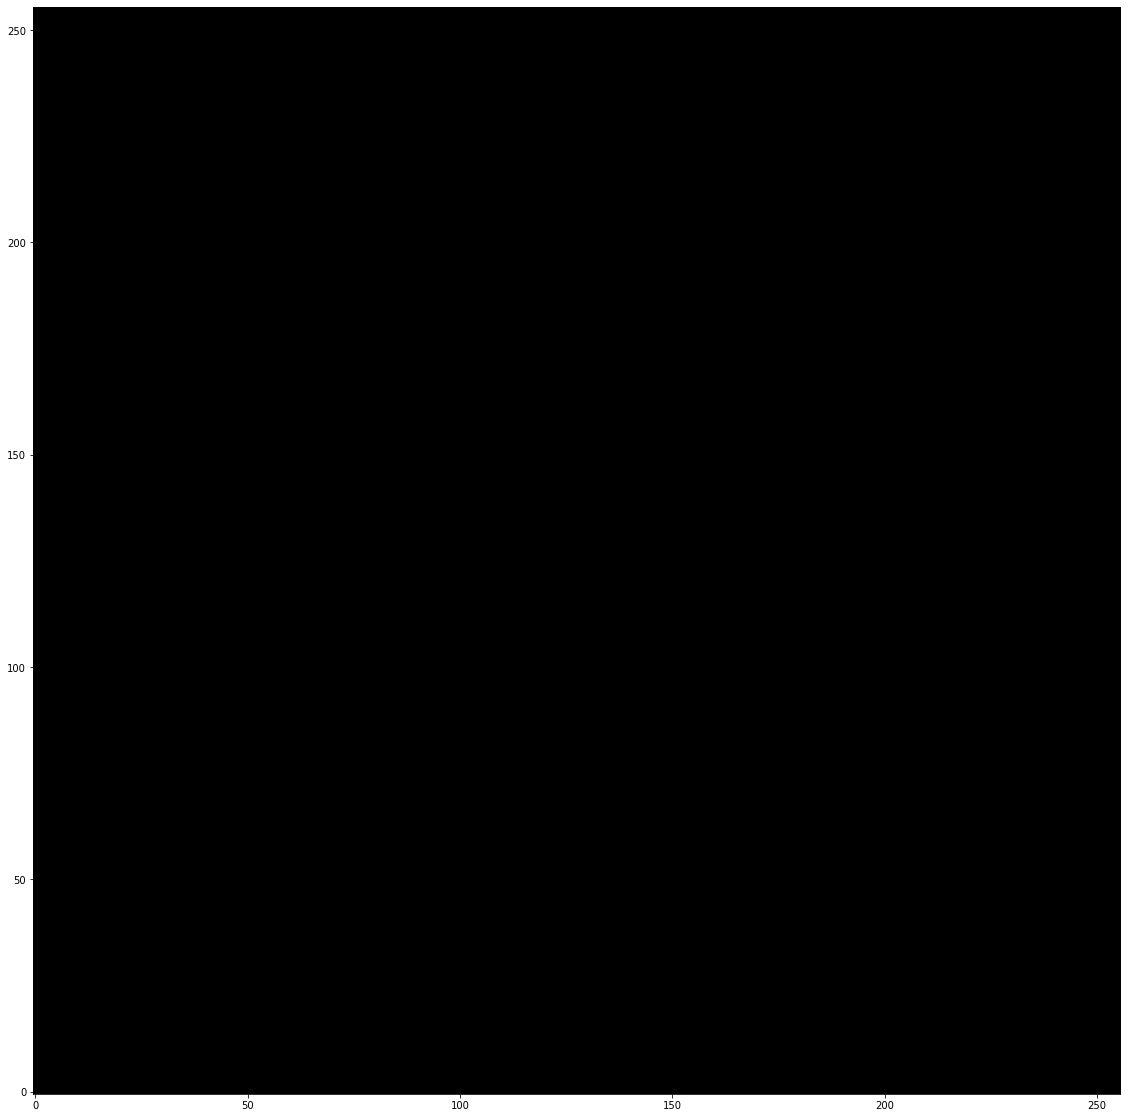

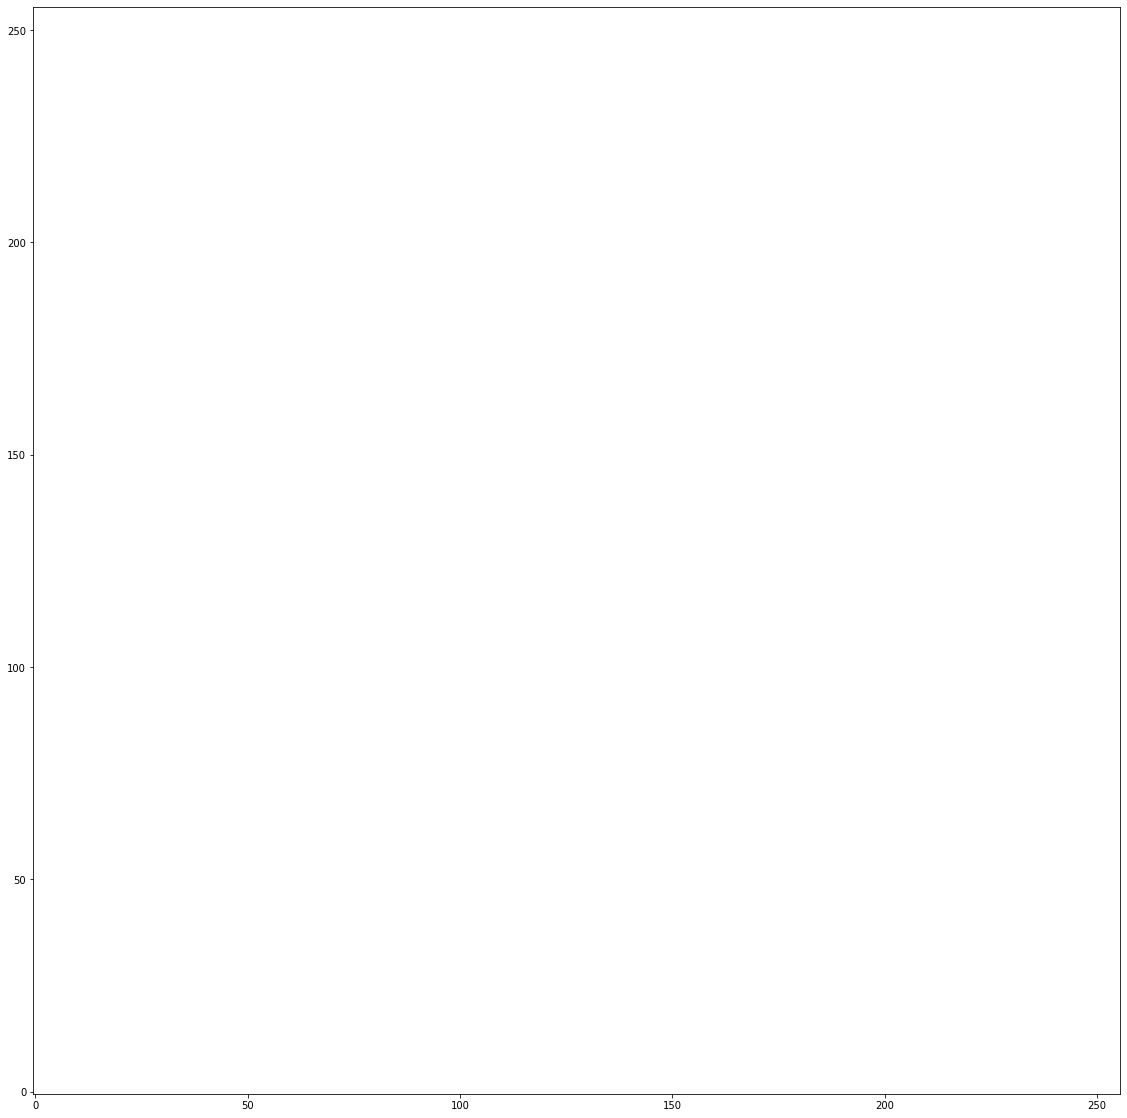

In [3]:
TestCompression(['zip'],data=src)

### JPEG good 420, unusable, tons of artifacts everywere (good compression ratio). Unusable

Created compressed db Compression ratio in comparison to source data 0.13
RMSE (preview): 8.610521631334066
diff [min, max, mean]: [0, 169, 12.705657958984375]
sm [min, max, mean]: [-0.05503361017929843, 0.9924809784962946, 0.8207307592694987]


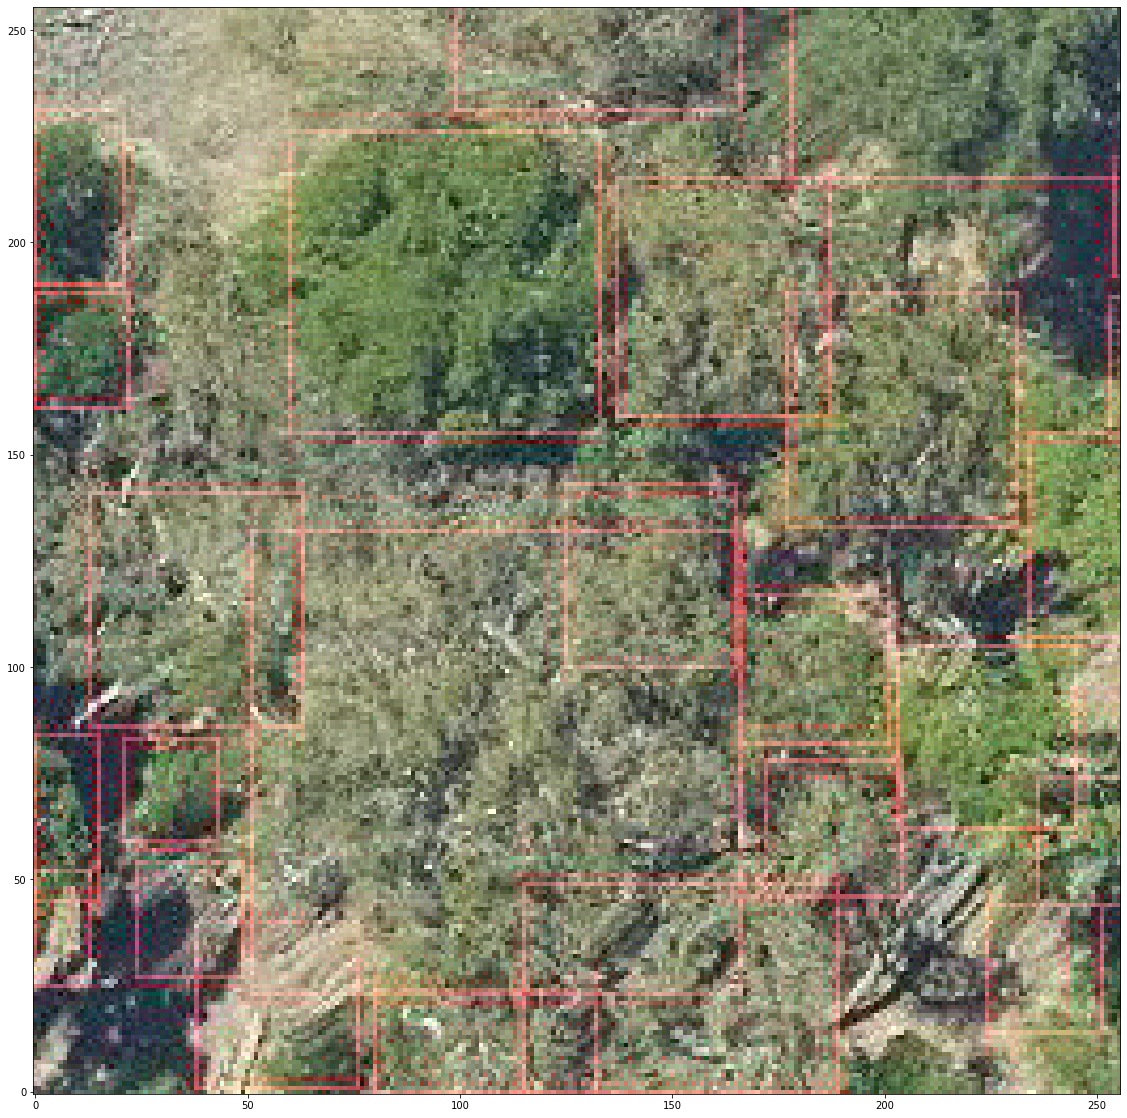

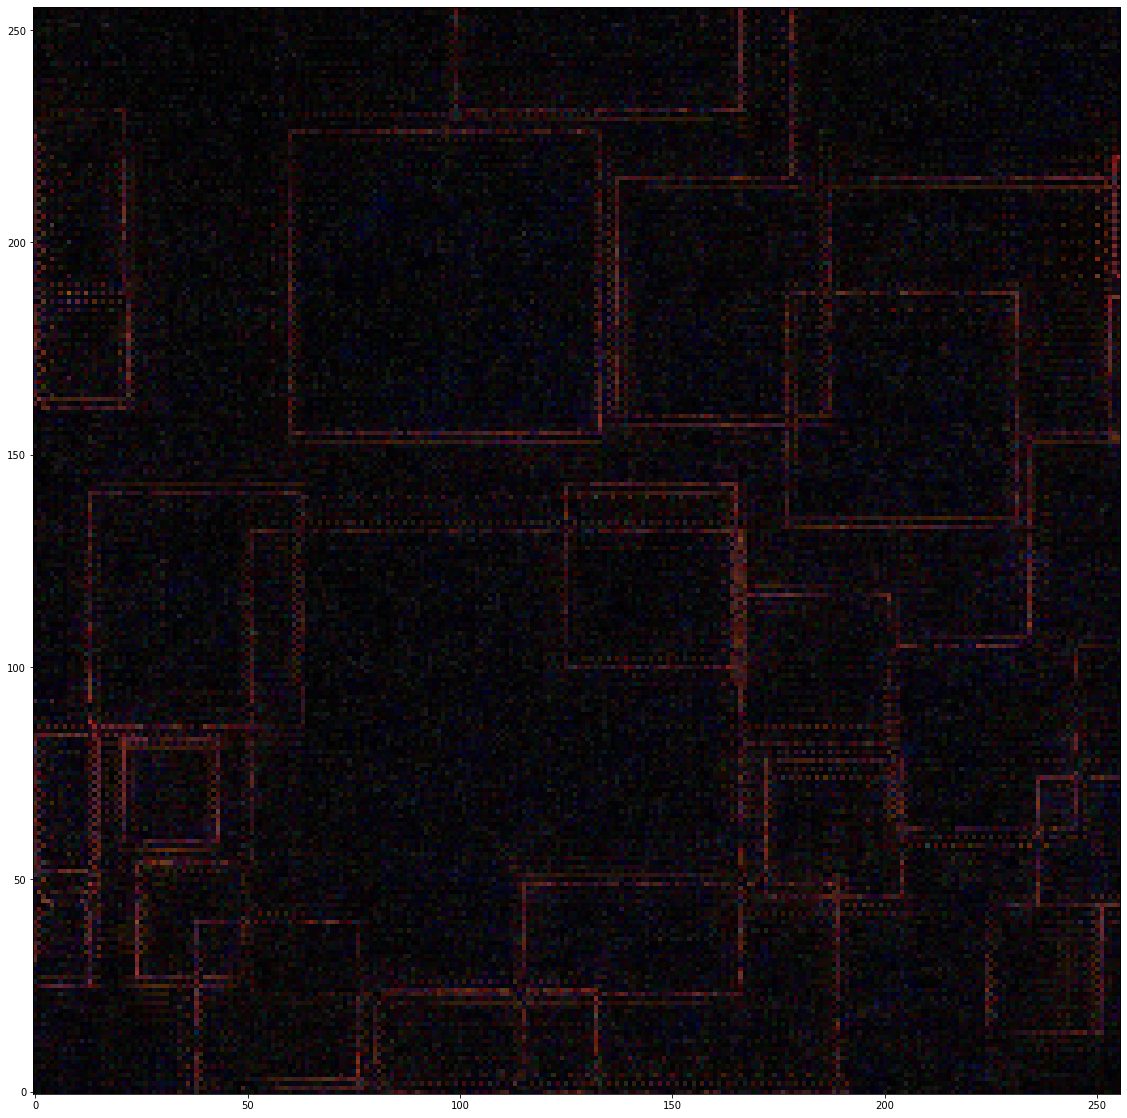

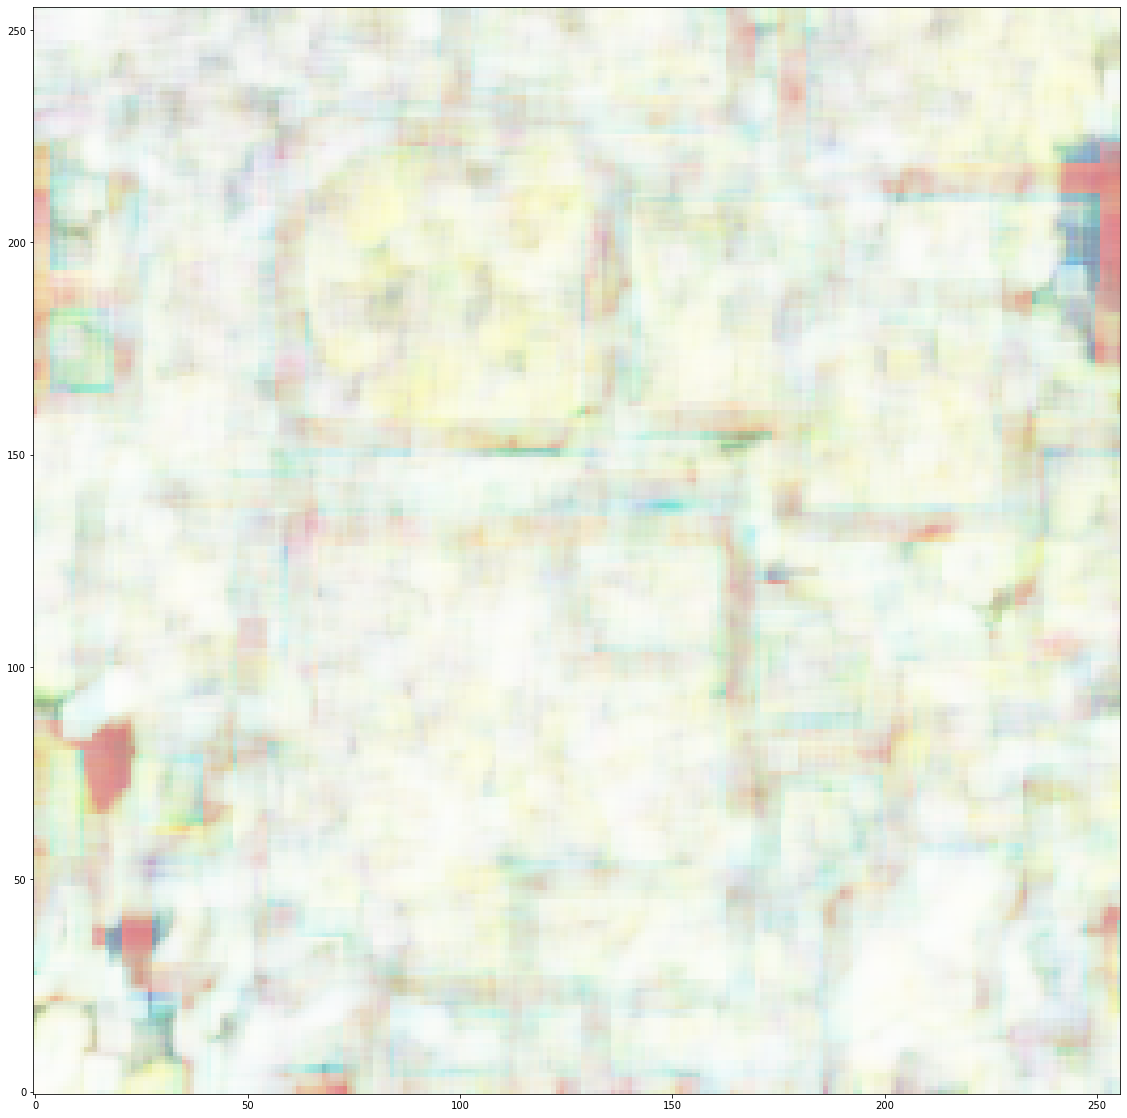

In [4]:
TestCompression(['jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE'],data=src)

### jpeg good 444. Random noise spread everywhere but low frequency. Kind of usable?

Created compressed db Compression ratio in comparison to source data 0.16
RMSE (preview): 8.121727230483685
diff [min, max, mean]: [0, 111, 9.438578287760416]
sm [min, max, mean]: [0.14546395357101355, 0.997938712048828, 0.8779524233106883]


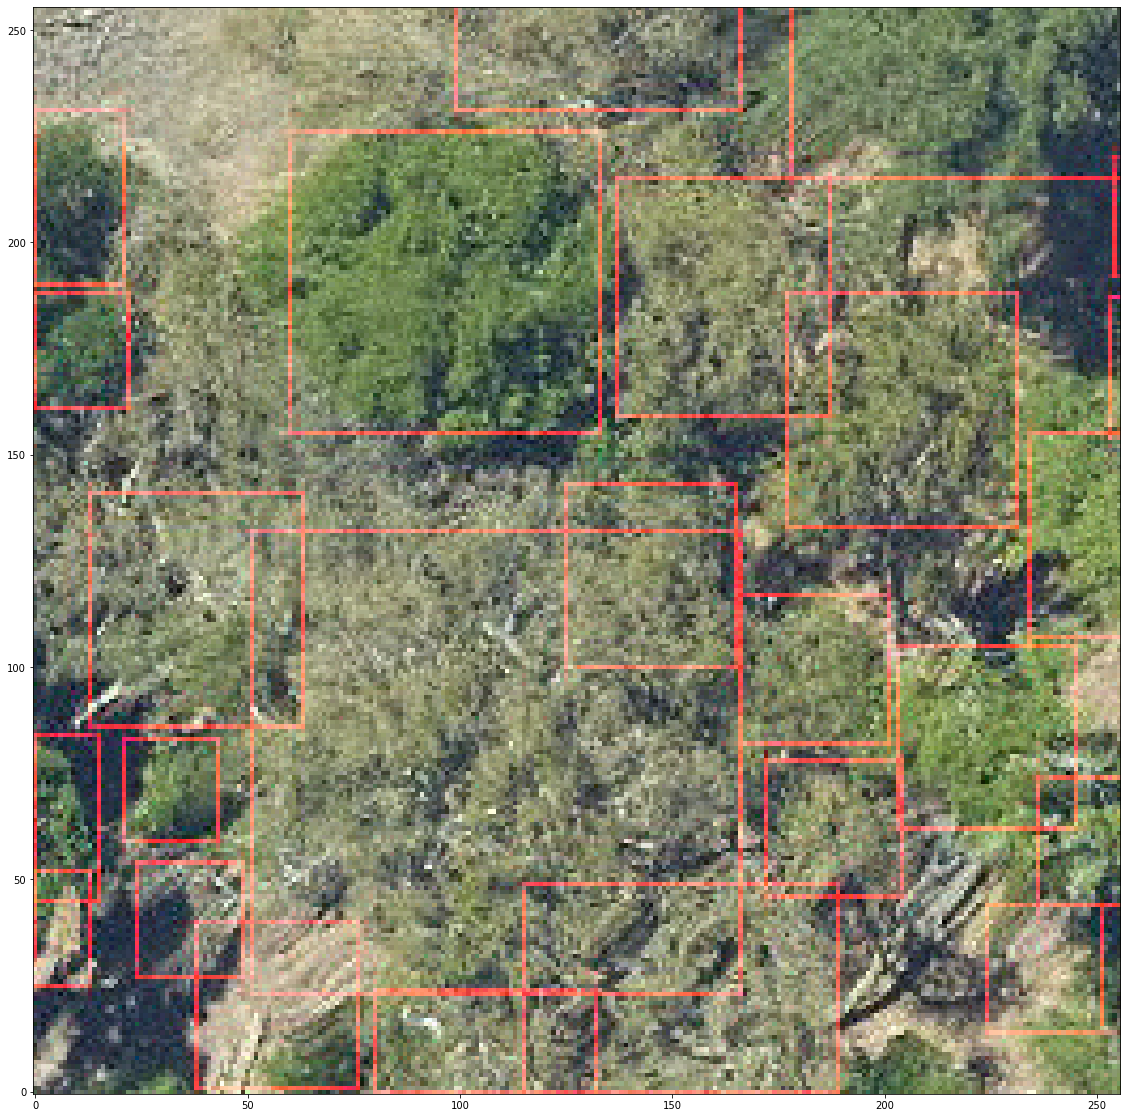

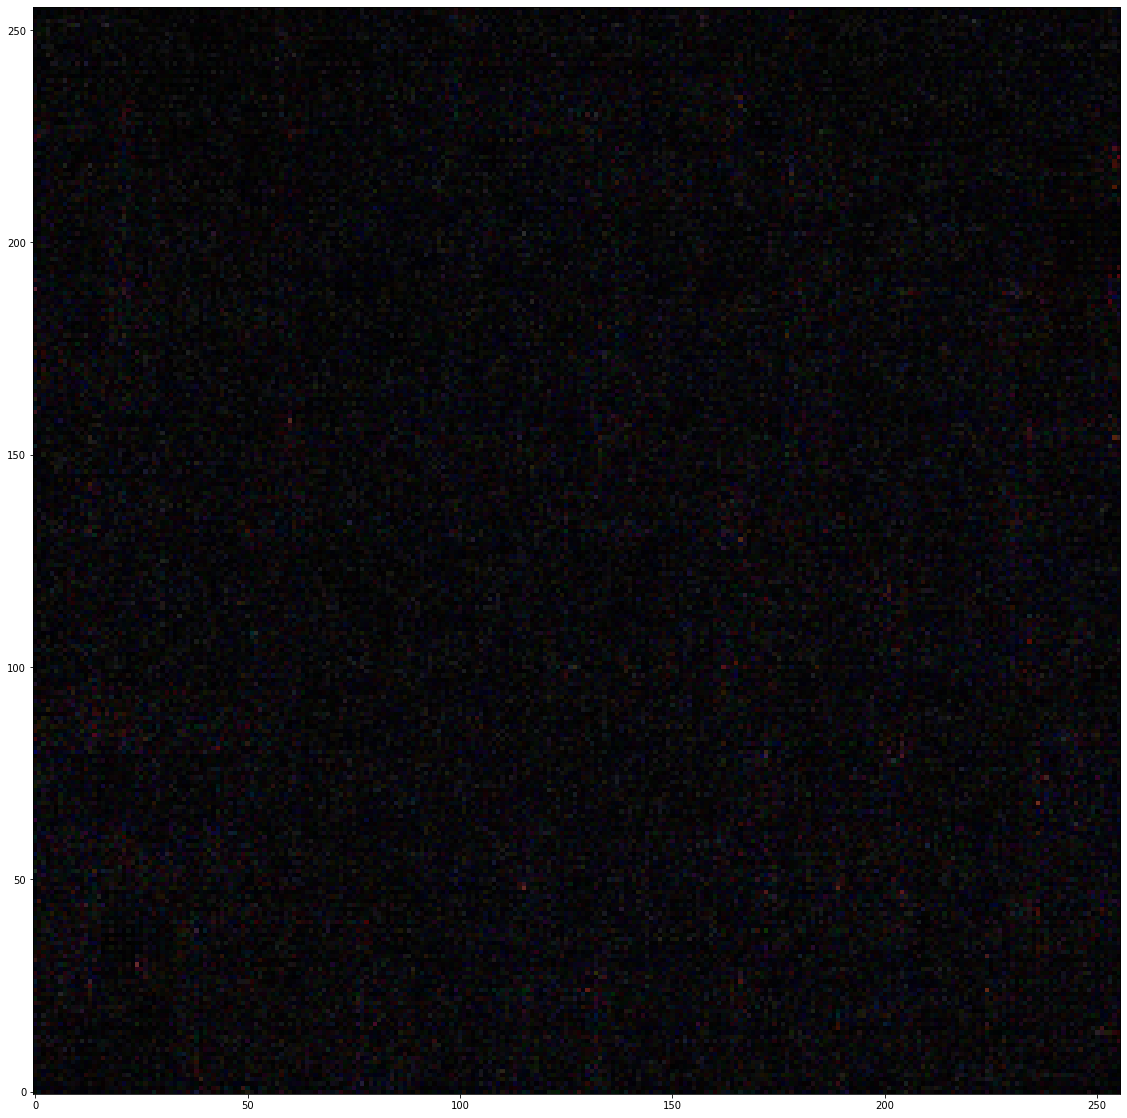

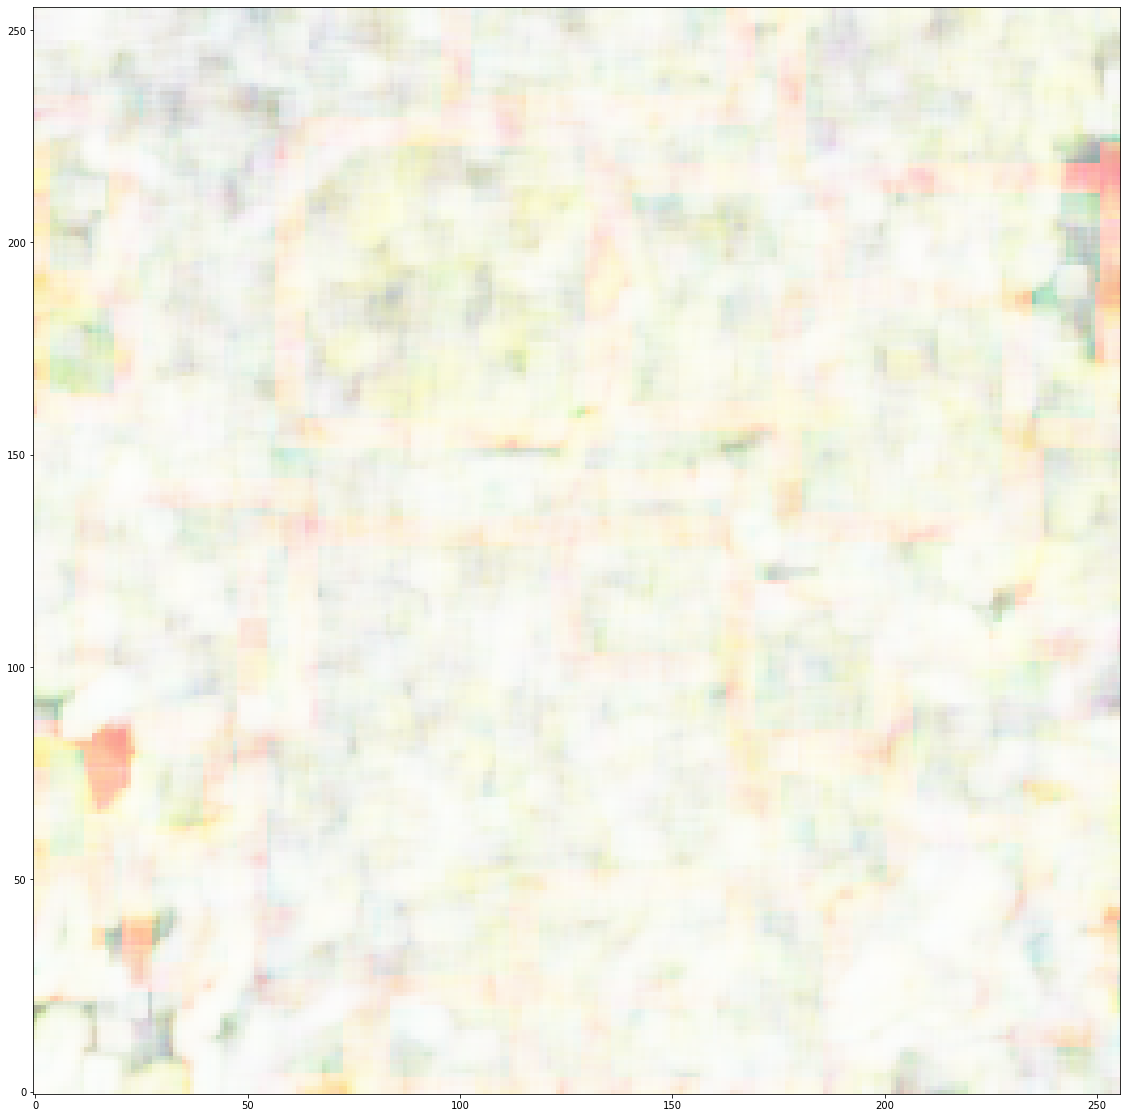

In [5]:
TestCompression(['jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE'],data=src)

### jpeg superb 420. Unusable tons of artifacts.

Created compressed db Compression ratio in comparison to source data 0.39
RMSE (preview): 7.234231924093637
diff [min, max, mean]: [0, 145, 9.020156860351562]
sm [min, max, mean]: [0.02063075474690399, 0.997305822570259, 0.8923807021012062]


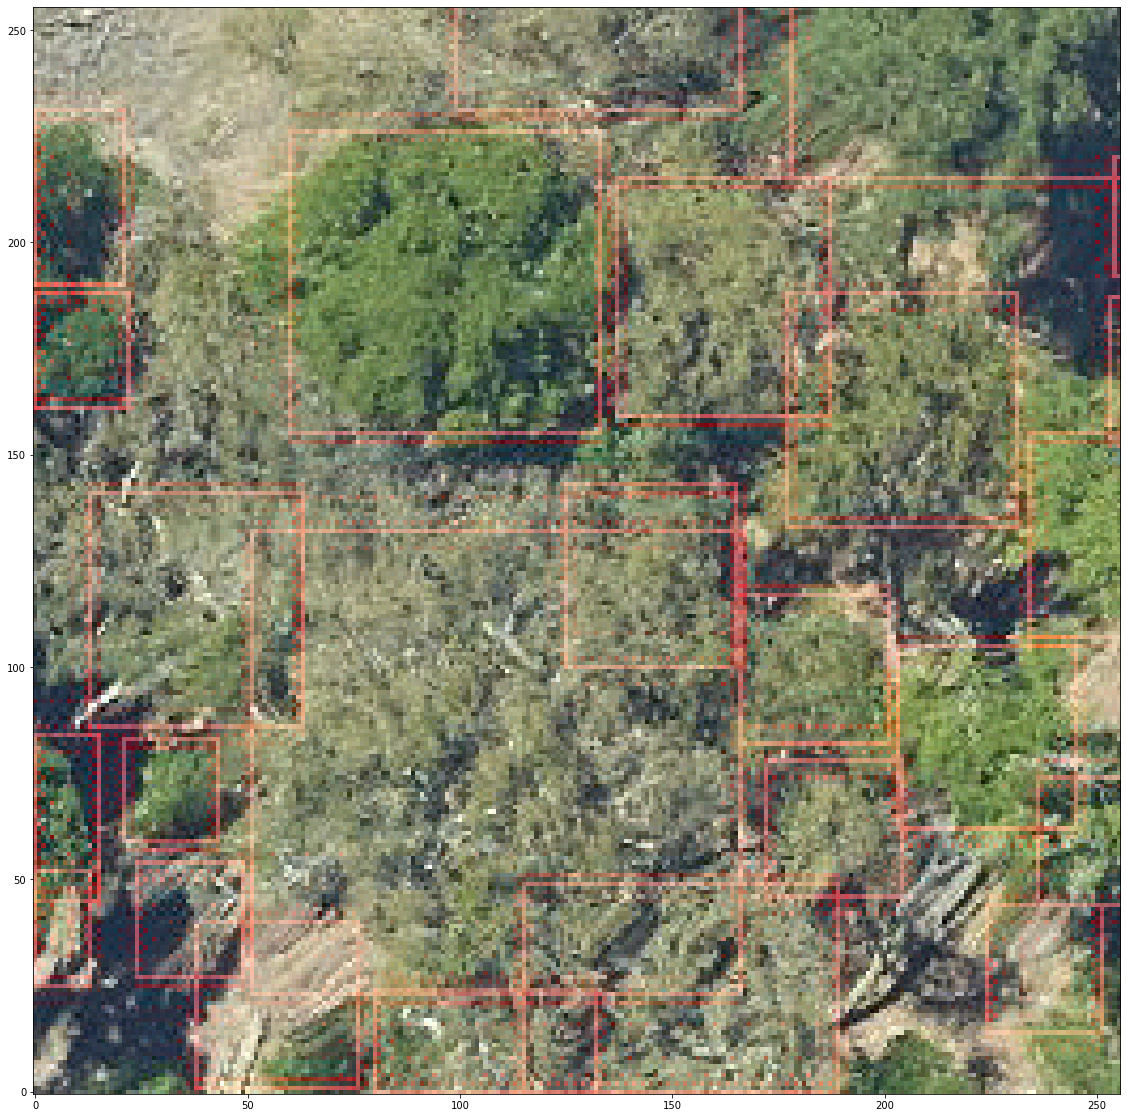

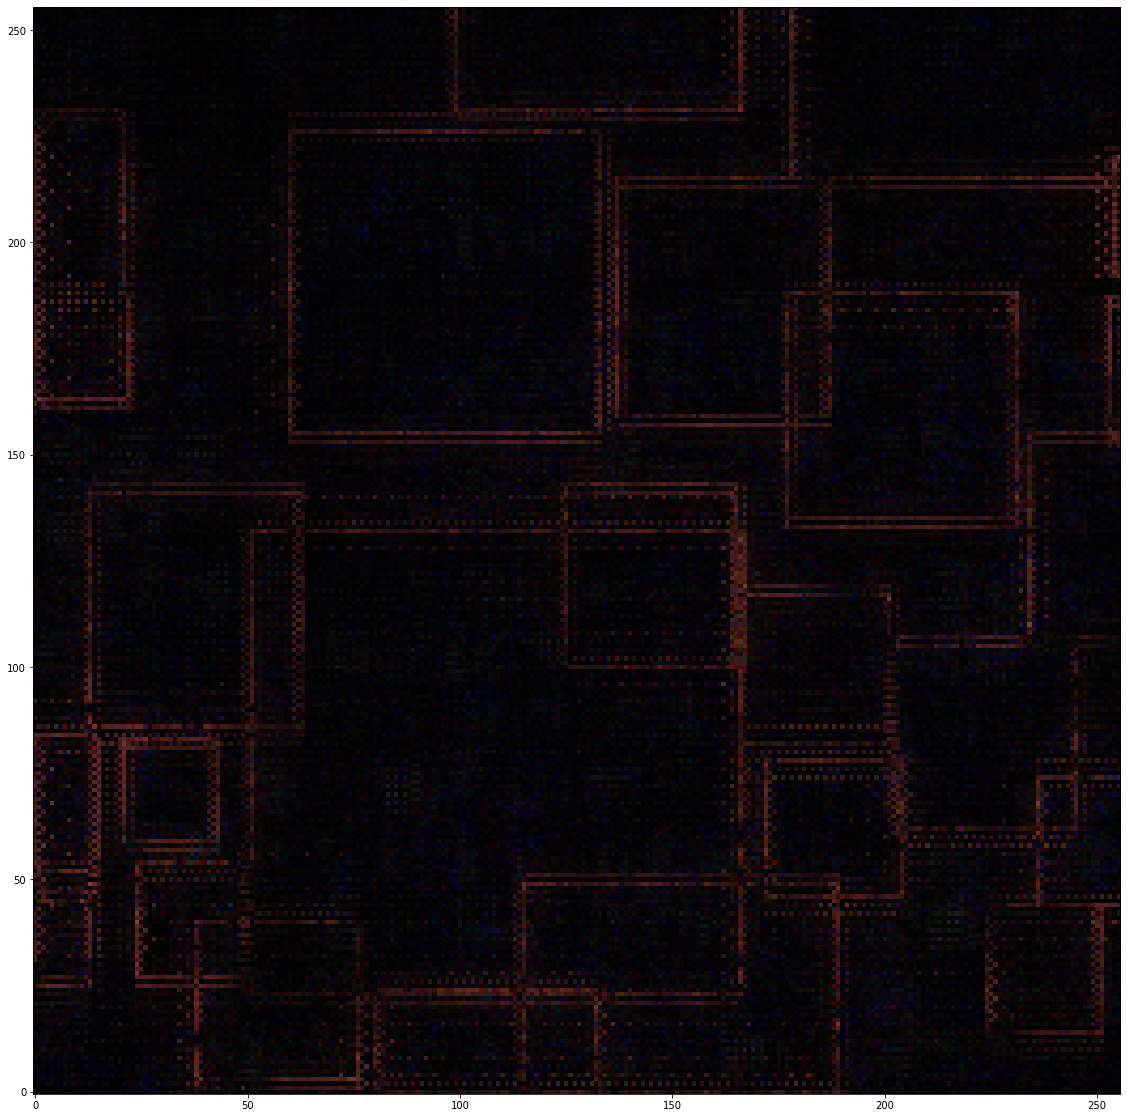

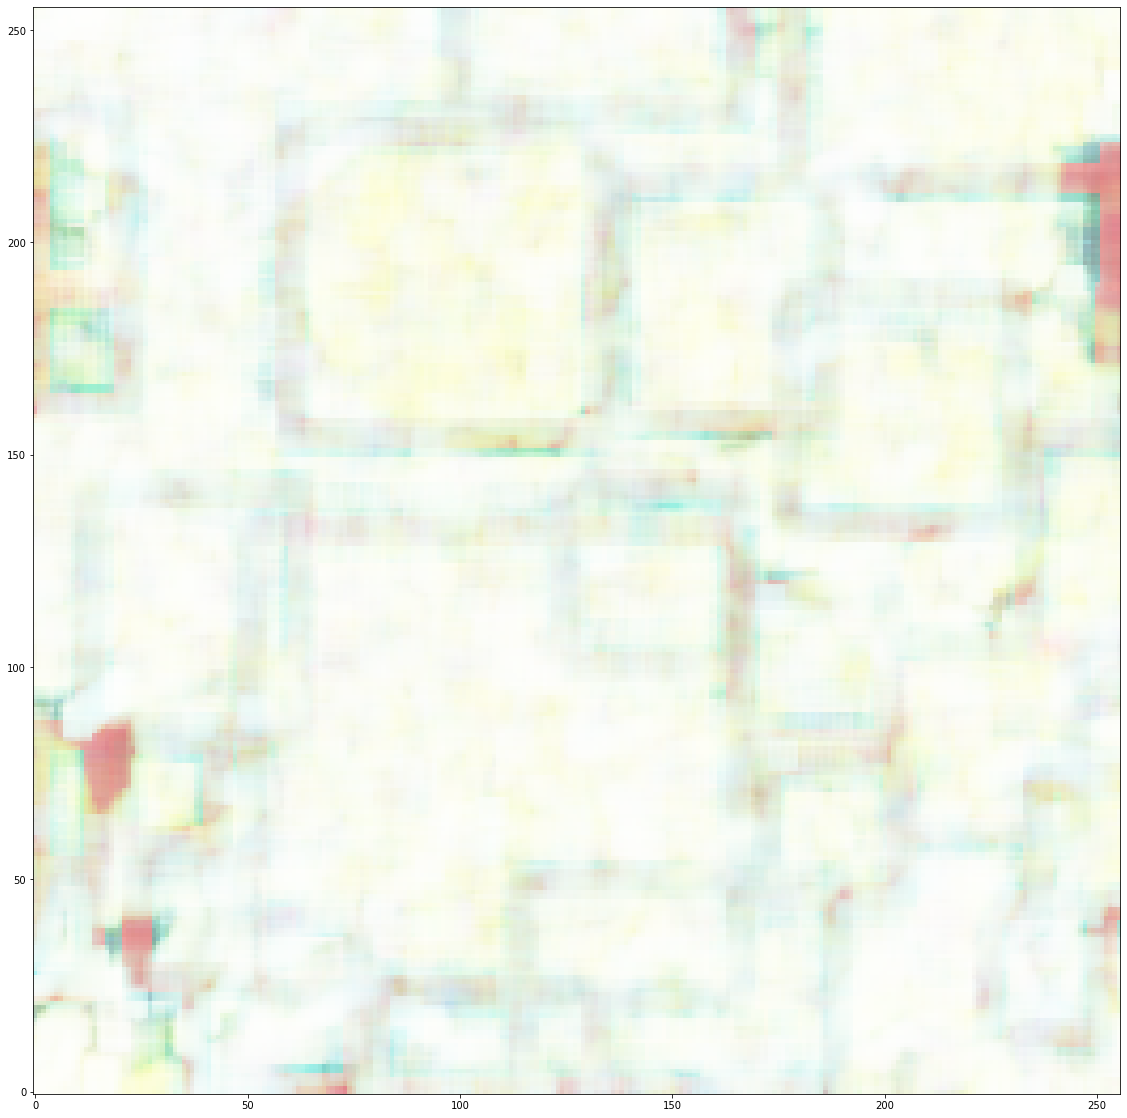

In [6]:
TestCompression(['jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE'],data=src)

### jpeg superb. Good quality but file too big.

Created compressed db Compression ratio in comparison to source data 0.69
RMSE (preview): 4.611261531311822
diff [min, max, mean]: [0, 37, 3.6030476888020835]
sm [min, max, mean]: [0.5862909760643077, 0.9996408321473265, 0.9817160664791627]


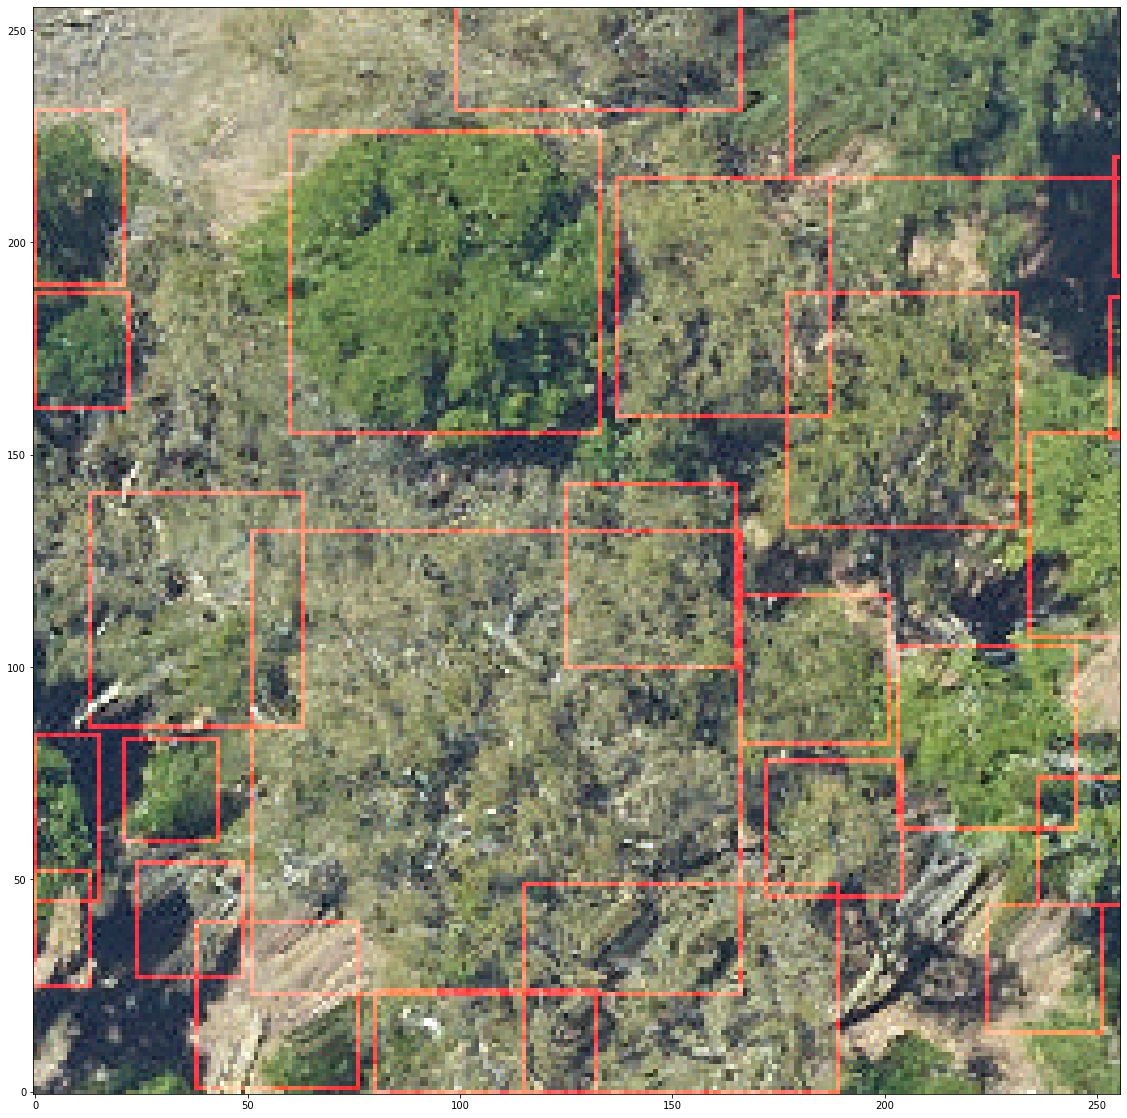

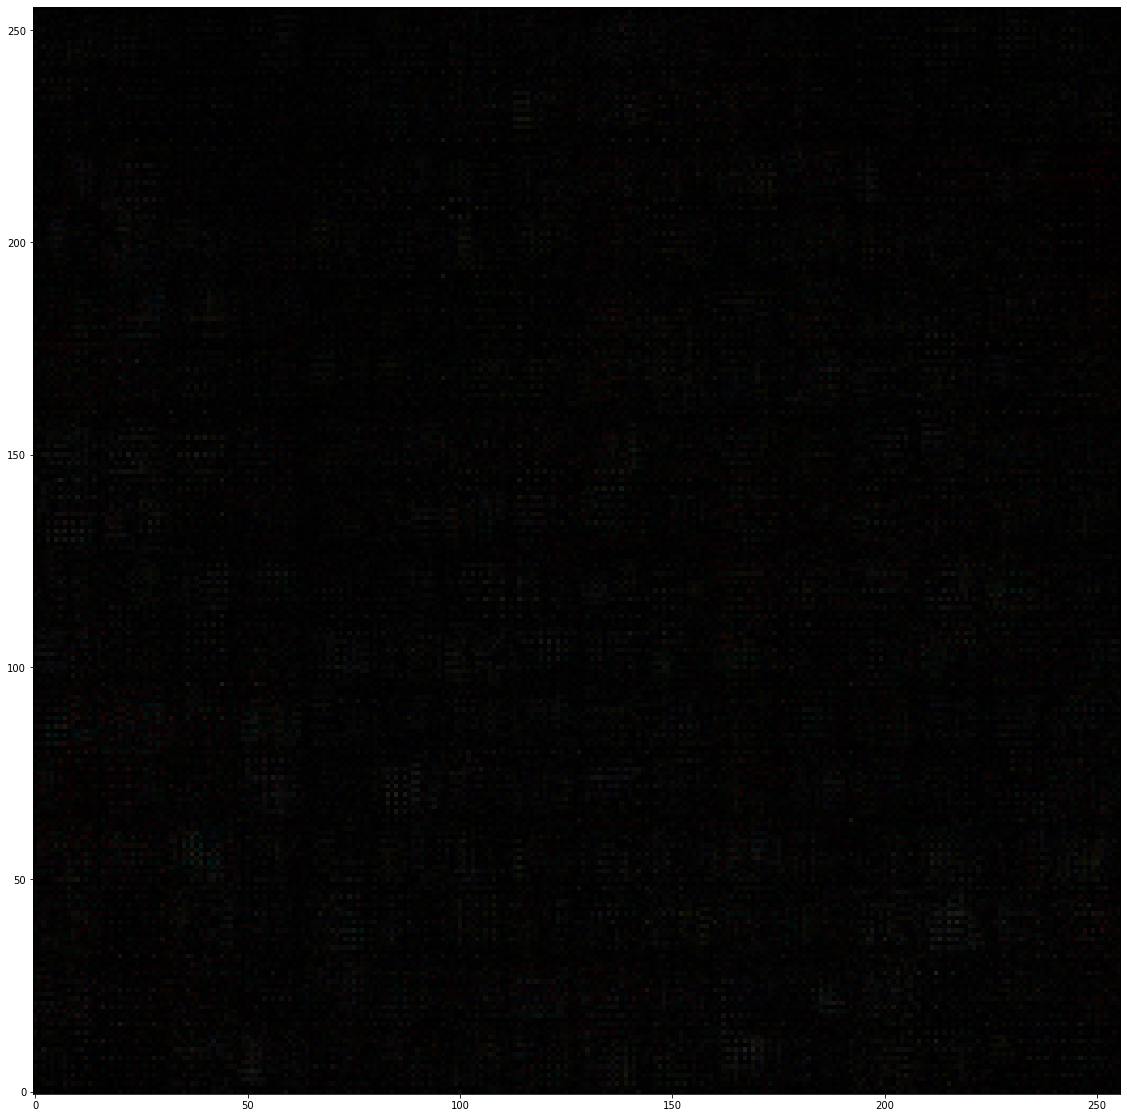

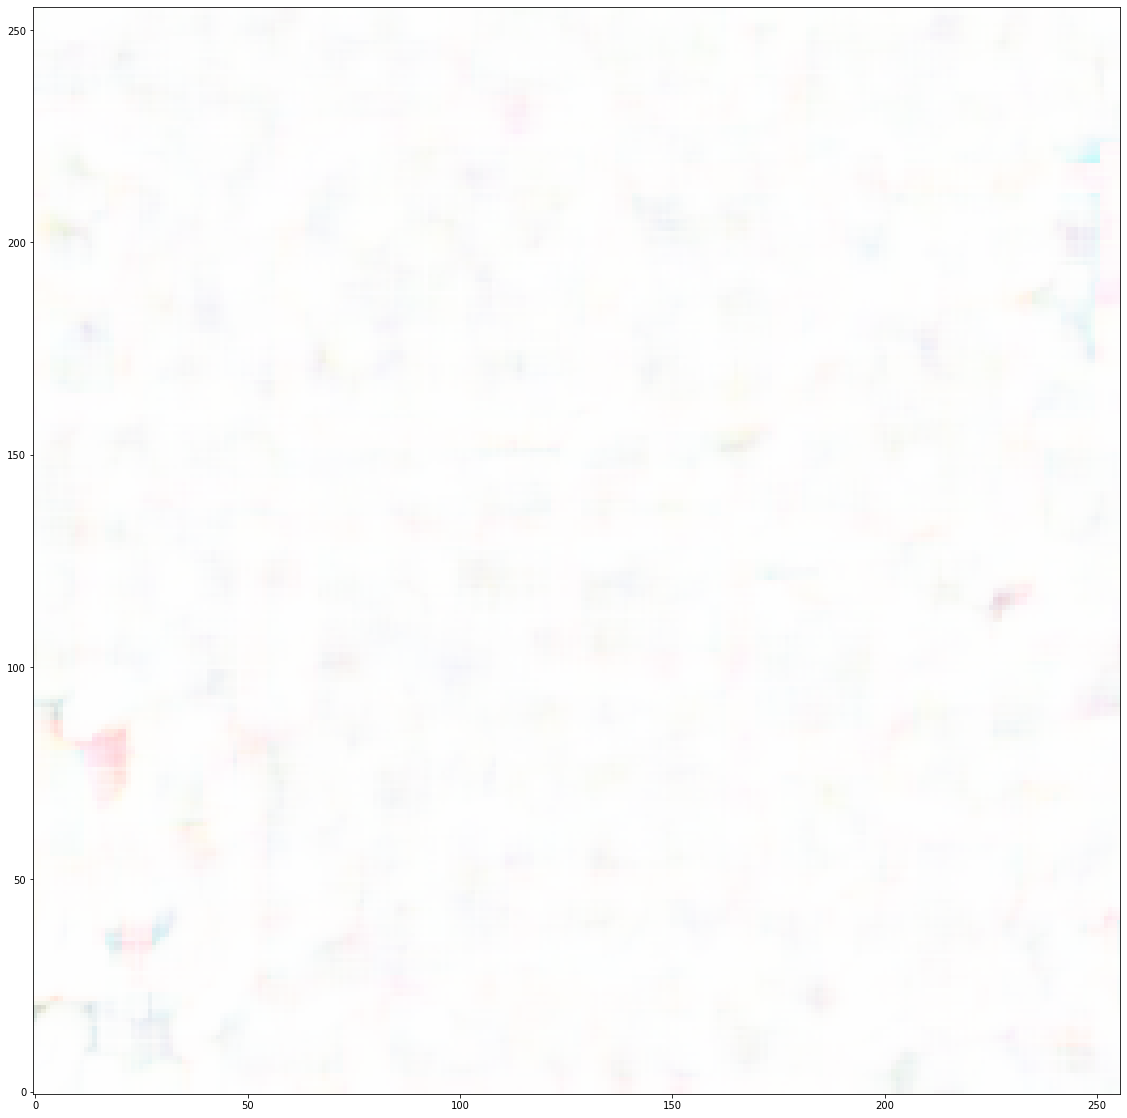

In [7]:
TestCompression(['jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE'],data=src)

### Conclusion. Use JPEG only for last N-levels (i.e. you are sure about 'vicinity')

Now it's possible to specify different compression for different levels. This example shows how to JPEG compress only last two levels; and compress all other levels using zip.

Created compressed db Compression ratio in comparison to source data 0.35
RMSE (preview): 6.9650533362557985
diff [min, max, mean]: [0, 100, 6.8665924072265625]
sm [min, max, mean]: [0.15349199579758757, 0.9989370902948886, 0.9100096156009245]


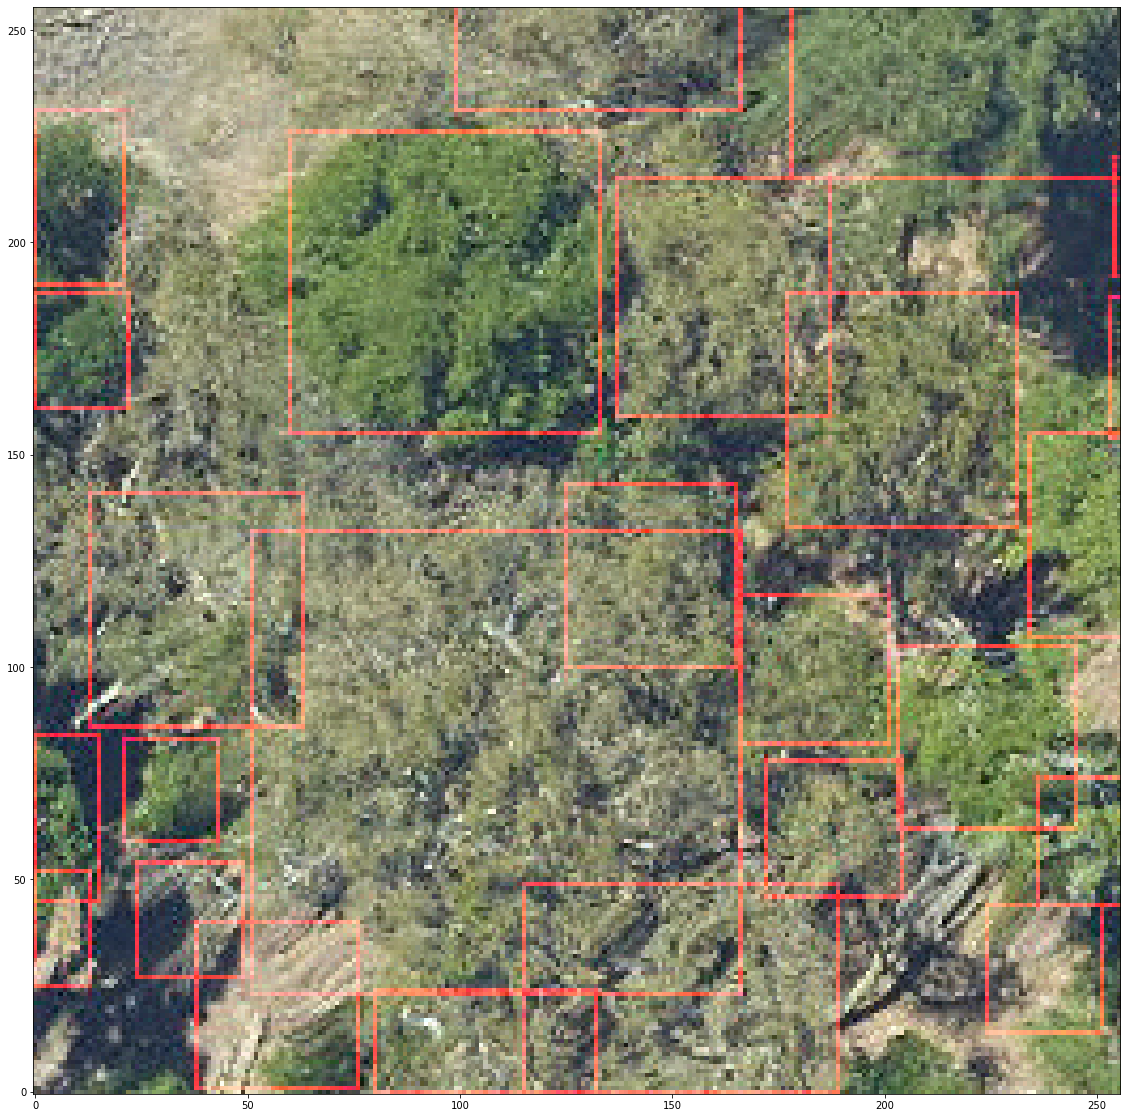

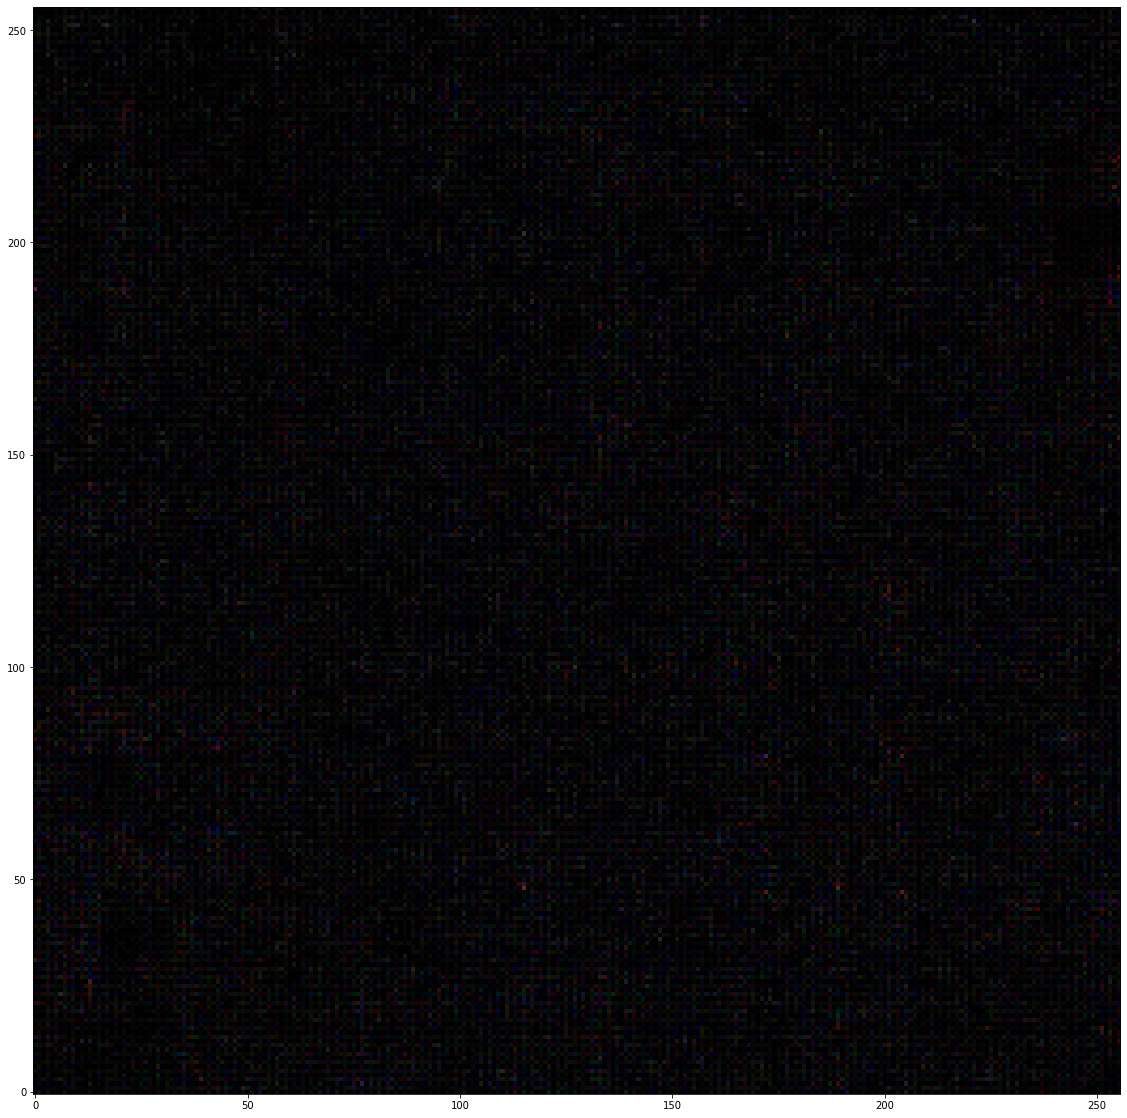

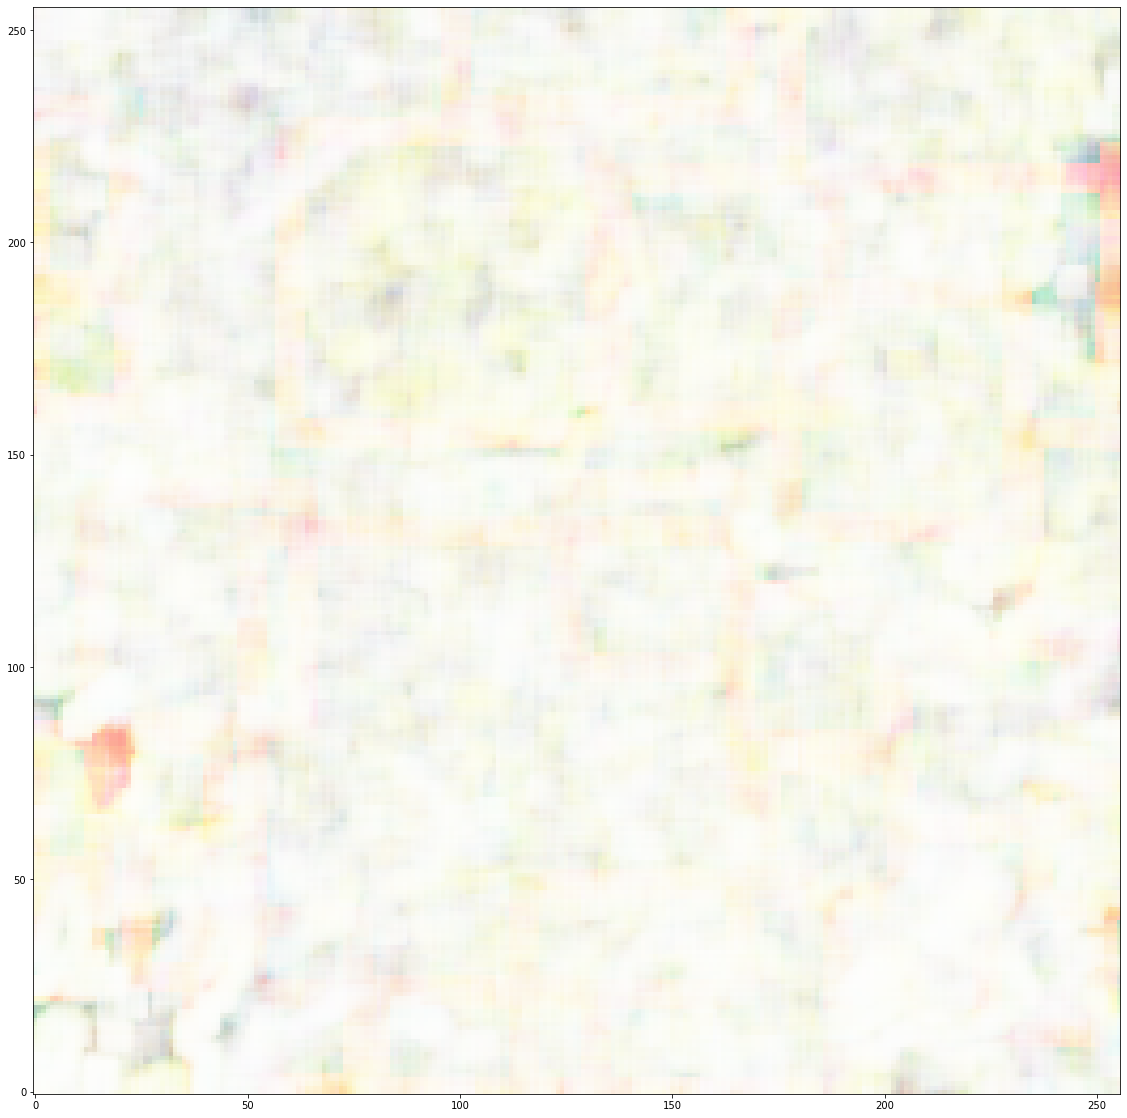

In [8]:
# last 2 levels jpeg
jpeg_good='jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE'
TestCompression(['zip',jpeg_good,jpeg_good],data=src)

Created compressed db Compression ratio in comparison to source data 0.25
RMSE (preview): 7.553027733694848
diff [min, max, mean]: [0, 101, 8.098673502604166]
sm [min, max, mean]: [0.15078613354601805, 0.9982692380723888, 0.8947990880499092]


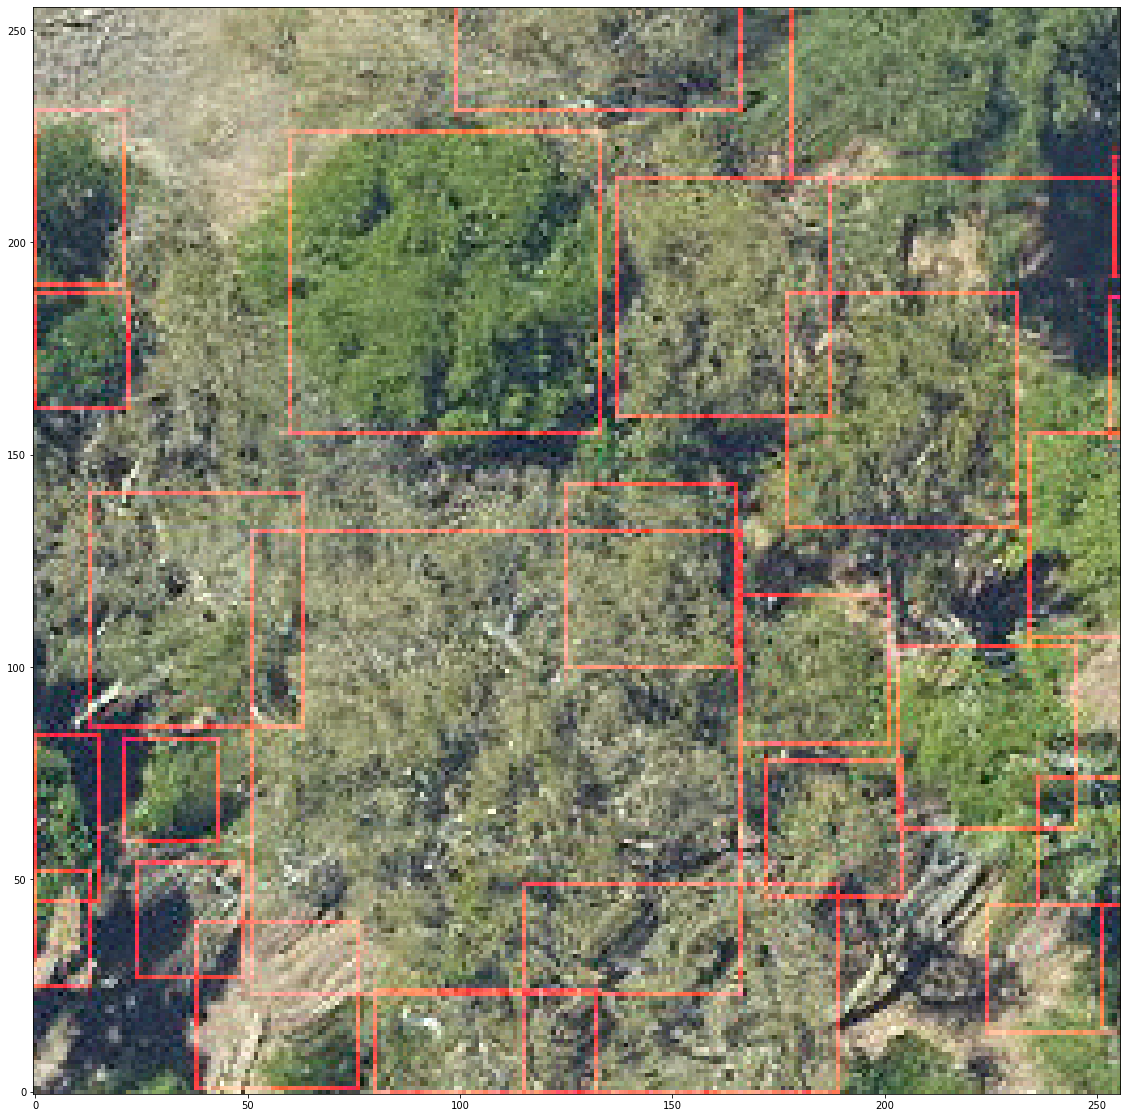

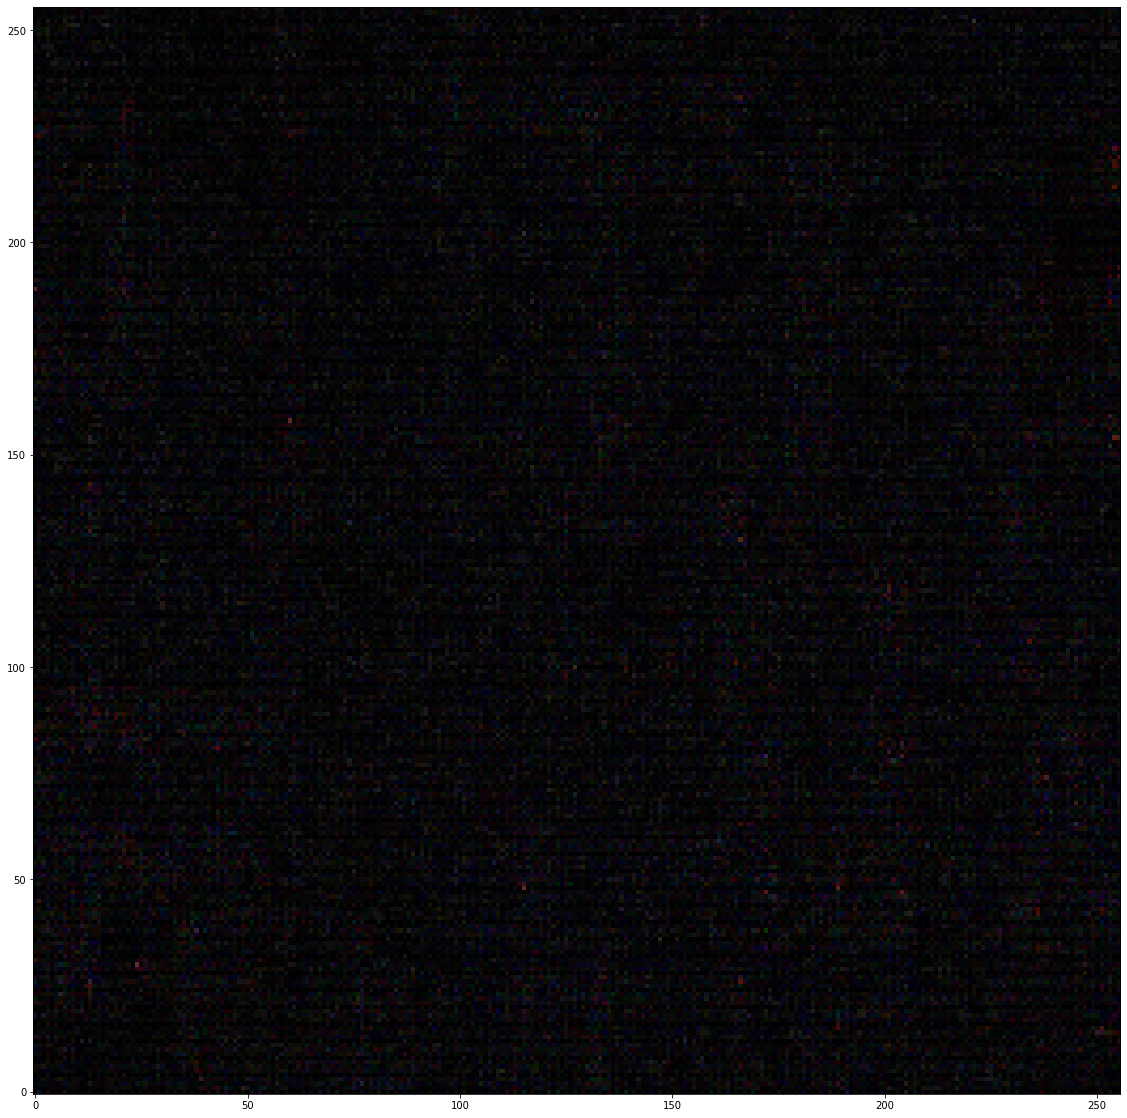

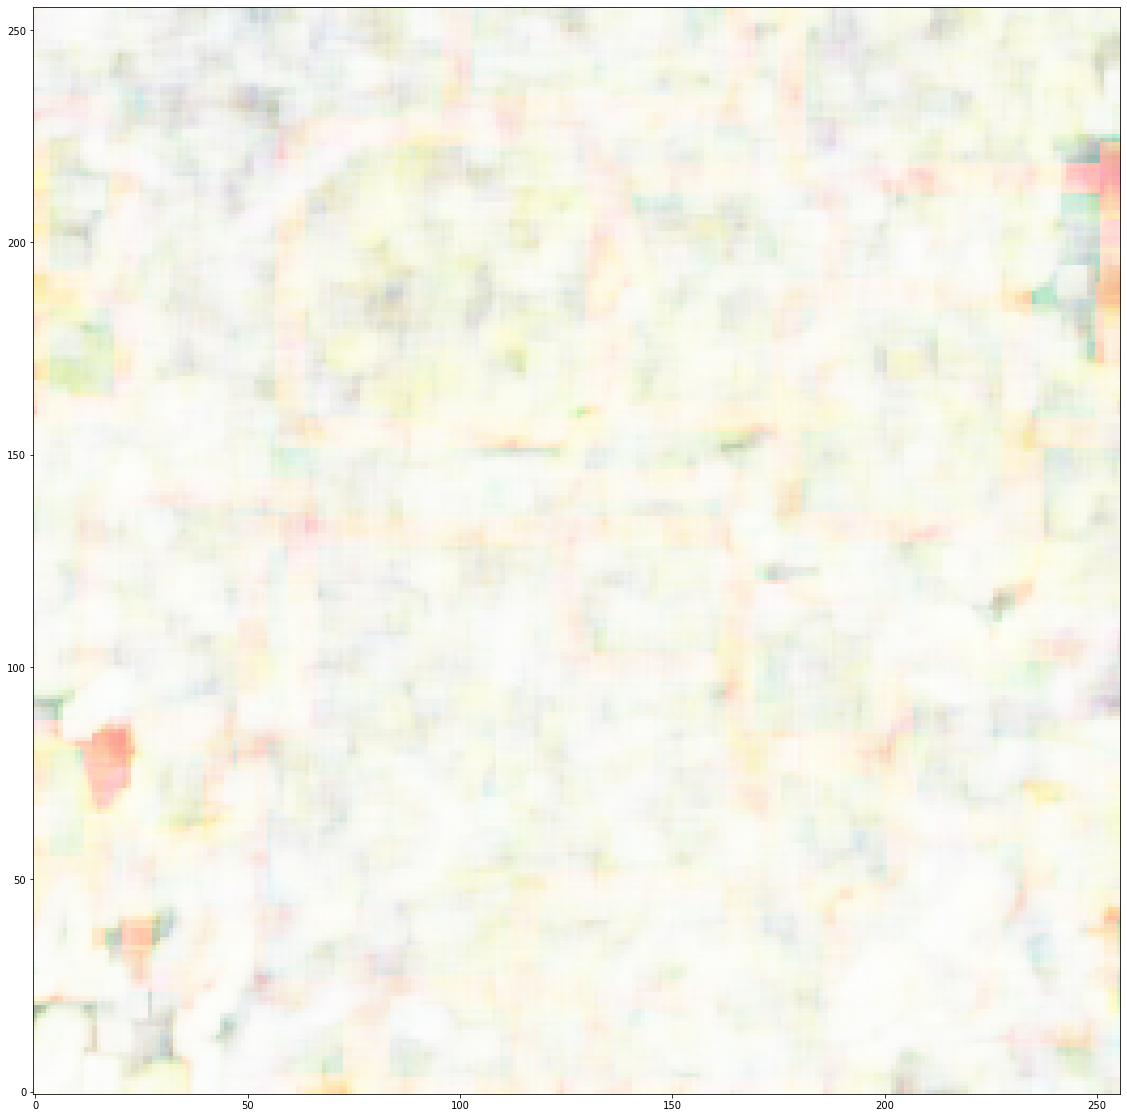

In [9]:
# last 3 levels jpeg
jpeg_good='jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE'
TestCompression(['zip',jpeg_good,jpeg_good,jpeg_good],data=src)